# Time Series

This example demonstrates operator learning for a time series with non-uniform time
steps.

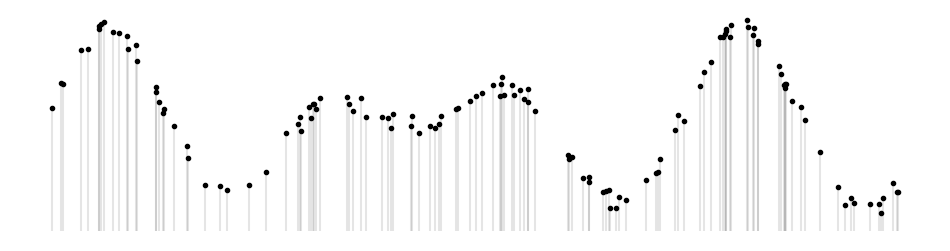

In [1]:
import torch
import matplotlib.pyplot as plt

t = torch.rand(128) * 4
f = 0.5 * (torch.sin(2 * torch.pi * t) + torch.sin(1.4 * torch.pi * t) + torch.rand_like(t) * 0.4) + 1

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, f, "k.")
for i, t in enumerate(t):
    ax.vlines(t, 0, f[i], color="k", alpha=0.1)
ax.axis("off")
plt.show()


Assume we have time-dependent data where the time
steps are at random locations and might change from sample to sample.
Actually, a discretization-invariant neural operator can learn
from an arbitrary discretization and generalize to a different ones!

## Setup

In [2]:
import torch
import matplotlib.pyplot as plt
from continuity.operators import BelNet
from continuity.data import OperatorDataset
from continuity.trainer import Trainer

In [3]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Problem

As a simple demonstration of the concepts, we will consider a sine
wave sampled on a non-uniform time grid. We consider function values evaluated
at 32 random positions in the interval [0, 1] as input, and a machine learning
model is supposed to predict 16 future function values on the interval [1, 1.5].

In [4]:
f = lambda t: torch.sin(2 * torch.pi * t)

def random_locations(num_sensors):
    return torch.sort(torch.rand(num_sensors))[0]

# History will be given as input
num_sensors = 32
t_hist = random_locations(num_sensors)

# Future will be given as labels
num_labels = 16
t_fut = 1 + 0.5 * random_locations(num_labels)

f_hist = f(t_hist)
f_fut = f(t_fut)

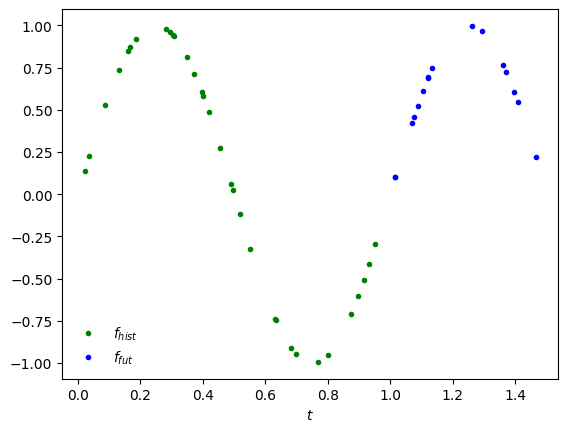

In [5]:
plt.plot(t_hist, f_hist, "g.", label=r"$f_{hist}$")
plt.plot(t_fut, f_fut, "b.", label=r"$f_{fut}$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

## Dataset

For training an operator, we first construct the corresponding `OperatorDataset`.

In [6]:
n_samples = 1
x_dim = u_dim = y_dim = v_dim = 1

x = t_hist.reshape(n_samples, num_sensors, x_dim)
u = f_hist.reshape(n_samples, num_sensors, u_dim)
y = t_fut.reshape(n_samples, num_labels, y_dim)
v = f_fut.reshape(n_samples, num_labels, v_dim)

dataset = OperatorDataset(x, u, y, v)

## Operator

We use BelNet, a discretization-invariant neural operator that
can interpolate between different input positions of samples.

In [7]:
operator = BelNet(dataset.shapes, K=1, D_1=16, D_2=16)

## Training

We train the operator on the given input discretization.

In [8]:
Trainer(operator).fit(dataset, tol=1e-5)

Model parameters: 33889
Device: mps
Epoch 559:  loss/train = 9.5844e-06  (0.040 s/epoch)


## Evaluation

Now, let's plot the predictions of the trained BelNet on the interval [1, 1.5].

Remarkably, the operator makes a good prediction even if we sample the sine wave
in new random time steps!

In [9]:
t_plot = torch.linspace(1, 1.5, 100).reshape(1, -1, 1)

# Time steps used for training
f_pred = operator(x, u, t_plot)    # x, u = t_hist, f_hist

# Different time steps
t_hist2 = random_locations(num_sensors)
f_hist2 = f(t_hist2)
x2 = t_hist2.reshape(1, -1, 1)
u2 = f_hist2.reshape(1, -1, 1)
f_pred2 = operator(x2, u2, t_plot) # x2, u2 = t_hist2, f_hist2

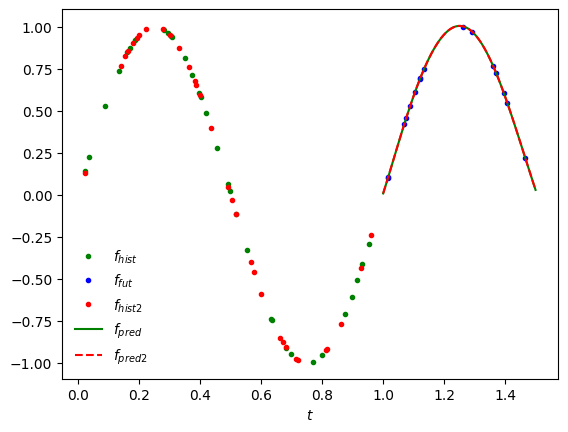

In [10]:
# Plot inputs and predictions
plt.plot(x.squeeze(), u.squeeze(), "g.", label=r"$f_{hist}$")
plt.plot(t_fut, f_fut, "b.", label=r"$f_{fut}$")
plt.plot(x2.squeeze(), u2.squeeze(), "r.", label=r"$f_{hist2}$")
plt.plot(t_plot.squeeze(), f_pred.squeeze().detach(), "g-", label=r"$f_{pred}$")
plt.plot(t_plot.squeeze(), f_pred2.squeeze().detach(), "r--", label=r"$f_{pred2}$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

This example demonstrates how useful it can be to consider functional
data as functions and apply machine learning to these functions directly.
This is what operator learning is about!